In [3]:
# sliding window GRU with attention, downsampling, and full evaluation
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Dropout, Bidirectional, Concatenate, Layer
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Claudia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
# Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.Wa = self.add_weight(name='Wa', shape=(input_shape[-1], input_shape[-1]), initializer='glorot_uniform', trainable=True)
        self.ba = self.add_weight(name='ba', shape=(input_shape[-1],), initializer='zeros', trainable=True)
        self.va = self.add_weight(name='va', shape=(input_shape[-1], 1), initializer='glorot_uniform', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        uit = tf.tanh(tf.tensordot(inputs, self.Wa, axes=1) + self.ba)
        ait = tf.nn.softmax(tf.tensordot(uit, self.va, axes=1), axis=1)
        weighted_input = inputs * ait
        return tf.reduce_sum(weighted_input, axis=1)

In [23]:
# Load and preprocess data
SEED = 42
np.random.seed(SEED)
df = pd.read_csv("msd_dataset_enriched_with_similar_songs.csv")
df = df[~df['genre'].isna() & ~df['lyrics'].isna()]
stopwords_set = set(stopwords.words('english'))

def clean_lyrics(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text.lower())
    tokens = text.split()
    return ' '.join([t for t in tokens if t not in stopwords_set])

df['cleaned_lyrics'] = df['lyrics'].apply(clean_lyrics)
genre_counts = df['genre'].value_counts()
valid_genres = genre_counts[genre_counts >= 20].index
df = df[df['genre'].isin(valid_genres)]


In [24]:
# Dynamically downsample overly dominant genres
threshold = 0.3 * len(df)
balanced_dfs = []
for genre, count in df['genre'].value_counts().items():
    genre_df = df[df['genre'] == genre]
    if count > threshold:
        genre_df = resample(genre_df, replace=False, n_samples=int(threshold), random_state=SEED)
    balanced_dfs.append(genre_df)
df = pd.concat(balanced_dfs).sample(frac=1, random_state=SEED)

# Tokenization
tokenized = df['cleaned_lyrics'].apply(str.split)
w2v_model = Word2Vec(sentences=tokenized, vector_size=50, window=5, min_count=3, workers=4)
valid_words = set(w2v_model.wv.index_to_key)

# Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_lyrics'])
filtered_index = {word: i+1 for i, word in enumerate(valid_words)}
tokenizer.word_index = filtered_index
tokenizer.index_word = {i: word for word, i in filtered_index.items()}

# Sliding windows
X_seq = []
y_seq = []
labels = df['genre'].tolist()
tokenized_seqs = tokenizer.texts_to_sequences(df['cleaned_lyrics'])

In [25]:
def create_sliding_windows(seq, window_size=100, step_size=50):
    windows = []
    for start in range(0, len(seq) - window_size + 1, step_size):
        windows.append(seq[start:start+window_size])
    if not windows and len(seq) > 0:
        windows.append(seq[:window_size])
    return windows

for i, seq in enumerate(tokenized_seqs):
    windows = create_sliding_windows(seq, window_size=100, step_size=50)
    for window in windows:
        padded = pad_sequences([window], maxlen=100)[0]
        X_seq.append(padded)
        y_seq.append(labels[i])

X = np.array(X_seq)
le = LabelEncoder()
y_labels = le.fit_transform(y_seq)
y = to_categorical(y_labels)

embedding_matrix = np.zeros((len(filtered_index) + 1, 50))
for word, i in filtered_index.items():
    embedding_matrix[i] = w2v_model.wv[word]

In [26]:
# Metadata features
meta_features = ['duration','tempo','key','loudness'] + [
    f'pitch_mean_{i}' for i in range(12)
] + [f'pitch_std_{i}' for i in range(12)] + [f'timbre_mean_{i}' for i in range(12)] + [f'timbre_std_{i}' for i in range(12)]
df[meta_features] = df[meta_features].fillna(0)
scaler = StandardScaler()

meta_rows = []
for i, seq in enumerate(tokenized_seqs):
    windows = create_sliding_windows(seq, window_size=100, step_size=50)
    num_windows = len(windows)
    meta_row = df.iloc[i][meta_features].values
    for _ in range(num_windows):
        meta_rows.append(meta_row)

X_meta_all = np.array(meta_rows)
X_meta_all = scaler.fit_transform(X_meta_all)

In [27]:
# Train/test split
X_train_lyrics, X_temp_lyrics, X_train_meta, X_temp_meta, y_train, y_temp, y_train_labels, y_temp_labels = train_test_split(
    X, X_meta_all, y, y_labels, test_size=0.3, stratify=y_labels, random_state=SEED
)

X_val_lyrics, X_test_lyrics, X_val_meta, X_test_meta, y_val, y_test, y_val_labels, y_test_labels = train_test_split(
    X_temp_lyrics, X_temp_meta, y_temp, y_temp_labels, test_size=0.5, stratify=y_temp_labels, random_state=SEED
)

In [28]:
# Model with Attention
input_lyrics = Input(shape=(100,))
x = Embedding(input_dim=embedding_matrix.shape[0], output_dim=50, weights=[embedding_matrix], trainable=False)(input_lyrics)
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = AttentionLayer()(x)
x = Dropout(0.3)(x)

input_meta = Input(shape=(X_train_meta.shape[1],))
combined = Concatenate()([x, input_meta])
output = Dense(y.shape[1], activation='softmax')(combined)

model = Model(inputs=[input_lyrics, input_meta], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
model.fit([X_train_lyrics, X_train_meta], y_train,
          validation_data=([X_val_lyrics, X_val_meta], y_val),
          batch_size=64, epochs=20, callbacks=[early], verbose=1)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.0927 - loss: 2.9041 - val_accuracy: 0.2788 - val_loss: 2.3712
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.2948 - loss: 2.3019 - val_accuracy: 0.3846 - val_loss: 2.1280
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.3891 - loss: 2.0493 - val_accuracy: 0.4231 - val_loss: 1.9609
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.4518 - loss: 1.9150 - val_accuracy: 0.4615 - val_loss: 1.8439
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4953 - loss: 1.7676 - val_accuracy: 0.4712 - val_loss: 1.7746
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5007 - loss: 1.6945 - val_accuracy: 0.5048 - val_loss: 1.6961
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.5237 - loss: 1.5836 - val_accuracy: 0.4808 - val_loss: 1.6884
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5328 - loss: 1.5215 - val_accuracy: 0.4856 - v

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Test Accuracy: 0.5598086124401914

Classification Report:
              precision    recall  f1-score   support

       Blues       0.00      0.00      0.00         7
     Country       0.44      0.27      0.33        15
  Electronic       0.00      0.00      0.00         4
       Metal       0.44      0.44      0.44         9
  Metal Rock       0.00      0.00      0.00         3
         Pop       0.44      0.24      0.31        17
    Pop Rock       0.00      0.00      0.00         3
        Punk       0.00      0.00      0.00         4
         Rap       0.77      0.92      0.84        60
      Reggae       0.00      0.00      0.00         6
         RnB       0.00      0.00      0.00         8
        Rock       0.47      0.88      0.61        56
  Rock Metal       0.50      0.12      0.20         8
    Rock Pop       0.00      0.00      0.00         5
   Rock Punk       0.00      0.00      0.00         4

    accuracy                         

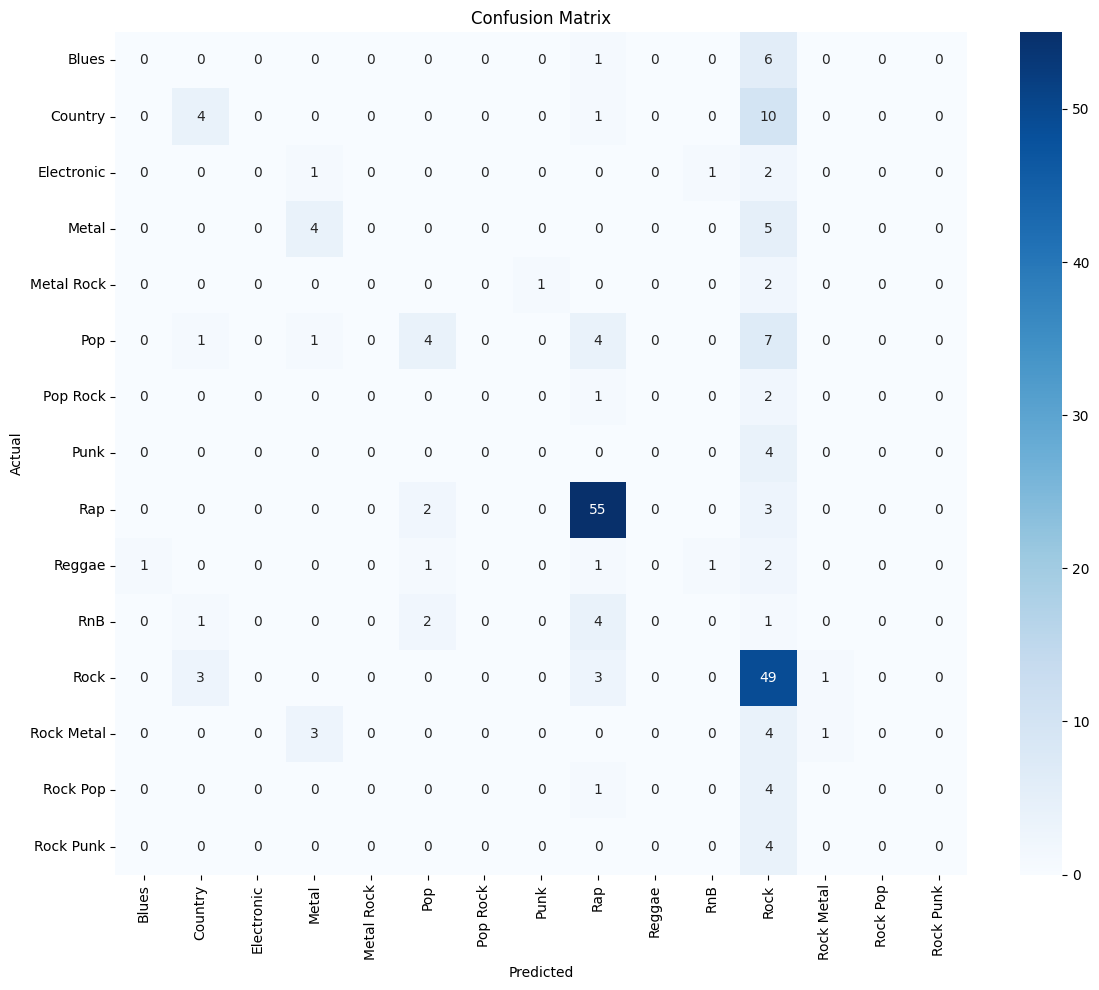

In [29]:
# Evaluation
y_pred = np.argmax(model.predict([X_test_lyrics, X_test_meta]), axis=1)
y_true = y_test_labels

print("\nTest Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_, zero_division=0))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
